In [3]:
import sys; sys.path.append('..'); from wwa import *

# fpath = "../../00_WWA_project_folder/ephemeral/Phillippines_wwa/"

xn, xx, yn, yx = [125, 127, 5, 10]

# sf = gpd.read_file("sf_philippines")

In [2]:
def rxnday(ds, n = 5):
    
    ts = xr.open_dataset(fpath+"obs/"+ds+"_daily.nc")
    ts = ts[list(ts.data_vars)[0]].rename("pr")
    
    ts = ts.rolling(time = n).sum().resample(time = "QS-DEC").max().groupby("time.season")["DJF"]
    ts = ts.assign_coords(time = ts.time.dt.year).rename("year")
    
    return ts

# Extract time series from other gridded obs

In [233]:
for fnm in sorted(glob.glob("../../00_WWA_project_folder/live/data/chirps_05/*.nc"))[-1:]:
    ds = xr.open_dataset(fnm).sel(longitude = slice(xn,xx), latitude = slice(yn,yx))
    ds.to_netcdf(fpath+"obs/"+fnm.split("/")[-1])

In [5]:
chirps = xr.open_mfdataset(fpath+"obs/chirps-v2*.nc").precip

chirps_rm = regionmask.mask_3D_geopandas(sf, chirps.longitude, chirps.latitude).squeeze(drop = True)
chirps_ts = chirps.where(chirps_rm == 1).mean(["latitude", "longitude"]).load()
chirps_ts.to_netcdf(fpath+"obs/chirps_daily.nc")

In [11]:
era5 = xr.open_dataset("era5_tp_daily_extended_125-127E_5-10N_su.nc").tp

era5_rm = regionmask.mask_3D_geopandas(sf, era5.lon, era5.lat).squeeze(drop = True)
era5_ts = era5.where(era5_rm == 1).mean(["lat", "lon"]).load()
era5_ts.to_netcdf(fpath+"obs/era5_daily.nc")

In [134]:
for fnm in glob.glob("../../00_WWA_project_folder/live/data/cpc/precip.*.nc"):
    ds = wrap_lon(xr.open_dataset(fnm)).sel(lon = slice(xn,xx), lat = slice(yn,yx))
    ds.to_netcdf(fpath+"obs/"+fnm.split("/")[-1])

cpc = xr.open_mfdataset(fpath+"obs/precip.*.nc").precip

cpc_rm = regionmask.mask_3D_geopandas(sf, cpc.lon, cpc.lat).squeeze(drop = True)
cpc_ts = cpc.where(cpc_rm == 1).mean(["lat", "lon"]).load()
cpc_ts.to_netcdf(fpath+"obs/cpc_daily.nc")

In [21]:
rxnday("chirps", 5).to_dataframe().to_csv("ts/chirps-rx5day.csv")
rxnday("era5", 5).to_dataframe().to_csv("ts/era5-rx5day.csv")
rxnday("mswep", 5).to_dataframe().to_csv("ts/mswep-rx5day.csv")

In [26]:
rxnday("chirps", 3).to_dataframe().to_csv("ts/chirps-rx3day.csv")
rxnday("era5", 3).to_dataframe().to_csv("ts/era5-rx3day.csv")
rxnday("mswep", 3).to_dataframe().to_csv("ts/mswep-rx3day.csv")

# Trend checking


## The event


In [12]:
chirps = xr.open_dataset(fpath+"obs/chirps_daily.nc").precip.sel(time = "2024")
mswep = xr.open_dataset(fpath+"obs/mswep_daily.nc").pr.sel(time = "2024")
era5 = xr.open_dataset(fpath+"obs/era5_daily.nc").tp.sel(time = "2024")

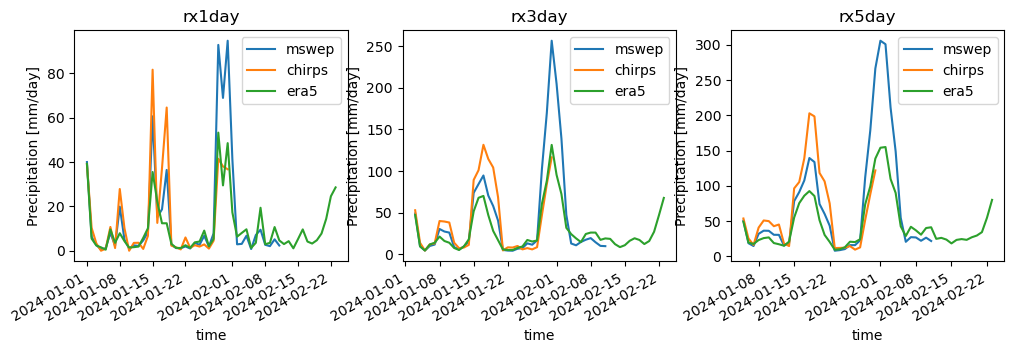

In [23]:
fig, axs = plt.subplots(ncols = 3, figsize = (12,3), dpi = 100)

for i in range(3):
    ax = axs[i]
    n = [1,3,5][i]
    mswep.rolling(time = n).sum().plot(ax = ax, label = "mswep")
    chirps.rolling(time = n).sum().plot(ax = ax, label = "chirps")
    era5.rolling(time = n).sum().plot(ax = ax, label = "era5")
    ax.legend()
    ax.set_title("rx"+str(n)+"day")


## Compare rxnday in obs

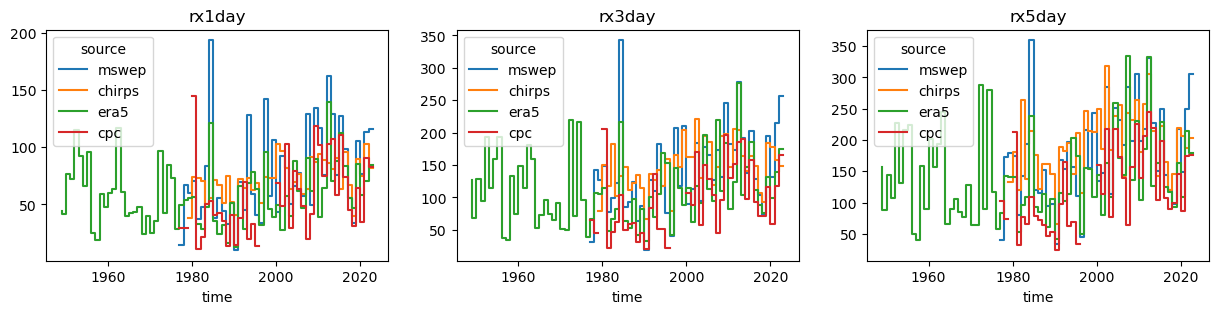

In [25]:
fig, axs = plt.subplots(ncols = 3, figsize = (15,3), dpi = 100)

for i in range(3):
    n = [1,3,5][i]
    ax = axs[i]
    
    rx = xr.concat([rxnday(ds, n).expand_dims(source = [ds]) for ds in ["mswep", "chirps", "era5", "cpc"]], "source").transpose().to_pandas()
    rx.plot(ax = ax, drawstyle = "steps")
    ax.set_title("rx"+str(n)+"day")

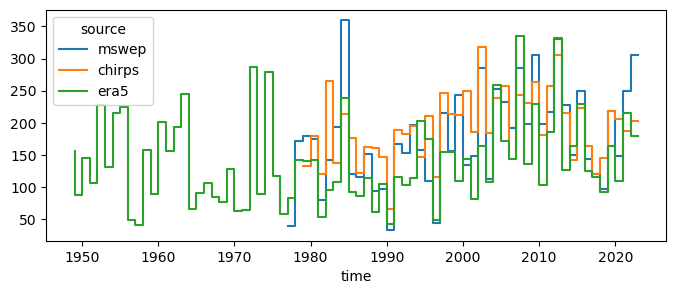

In [15]:
fig, axs = plt.subplots(ncols = 1, figsize = (8,3), dpi = 100)
n = 5
rx = xr.concat([rxnday(ds, n).expand_dims(source = [ds]) for ds in ["mswep", "chirps", "era5"]], "source").transpose().to_pandas()
rx.plot(ax = axs, drawstyle = "steps")
ax.set_title("rx"+str(n)+"day")

plt.savefig("fig/obs_rx5day_timeseries.png")

## Assumption of constant dispersion

## Observations

Text(0.5, 1.02, 'Mean, SD & dispersion in rx1day')

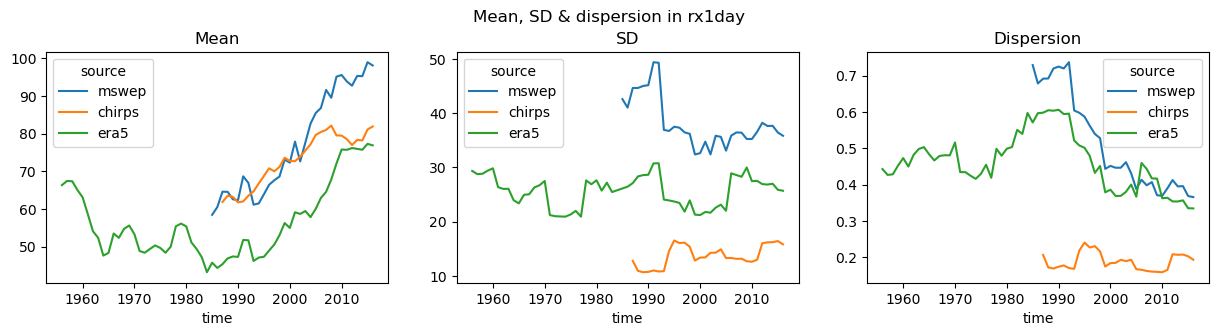

In [211]:
fig, axs = plt.subplots(ncols = 3, figsize = (15,3), dpi = 100)

ts = xr.concat([rxnday(ds, 1).expand_dims(source = [ds]) for ds in ["mswep", "chirps", "era5"]], "source").transpose().to_pandas()

ts.rolling(15, center = True).mean().plot(ax = axs[0])
axs[0].set_title("Mean")

ts.rolling(15, center = True).std().plot(ax = axs[1])
axs[1].set_title("SD")

(ts.rolling(15, center = True).std() / ts.rolling(15, center = True).mean()).plot(ax = axs[2])
axs[2].set_title("Dispersion")

plt.suptitle("Mean, SD & dispersion in rx1day", y = 1.02)


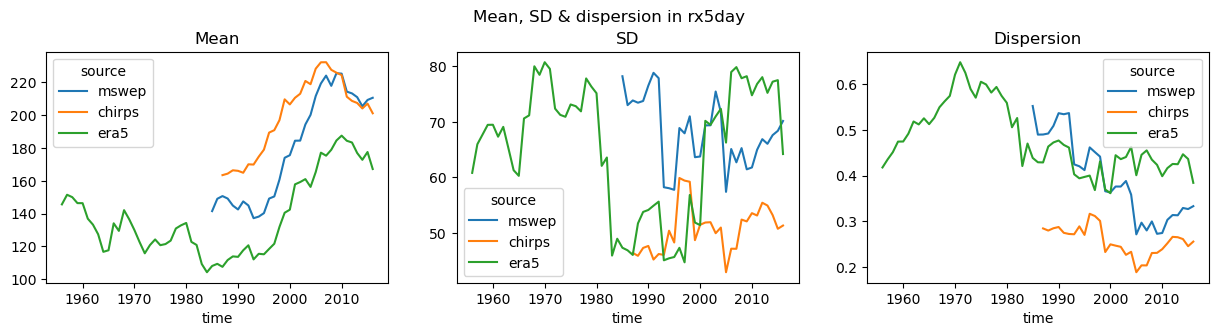

In [212]:
fig, axs = plt.subplots(ncols = 3, figsize = (15,3), dpi = 100)

ts = xr.concat([rxnday(ds, 5).expand_dims(source = [ds]) for ds in ["mswep", "chirps", "era5"]], "source").transpose().to_pandas()

ts.rolling(15, center = True).mean().plot(ax = axs[0])
axs[0].set_title("Mean")

ts.rolling(15, center = True).std().plot(ax = axs[1])
axs[1].set_title("SD")

(ts.rolling(15, center = True).std() / ts.rolling(15, center = True).mean()).plot(ax = axs[2])
axs[2].set_title("Dispersion")

plt.suptitle("Mean, SD & dispersion in rx5day", y = 1.02)

plt.savefig("fig/obs_rx5day_dispersion.png")

### CORDEX

Text(0.5, 1.0, 'Dispersion')

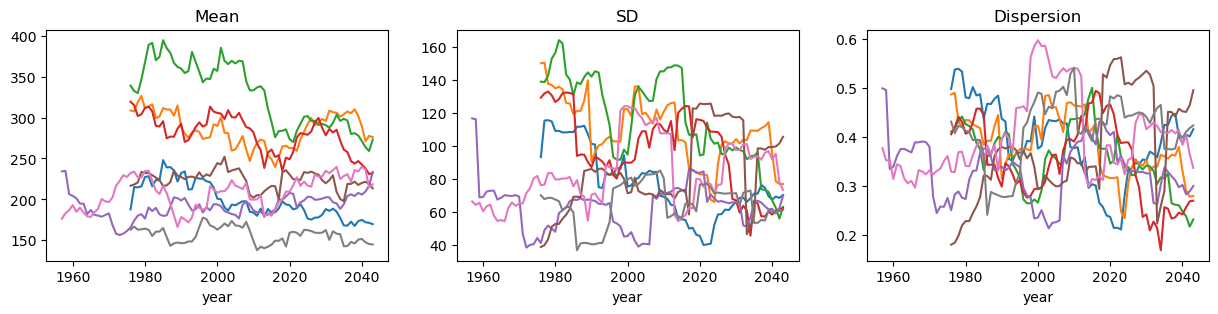

In [121]:
fig, axs = plt.subplots(ncols = 3, figsize = (15,3), dpi = 100)
for fnm in glob.glob(fpath+"ts/*.dat"):
    df = pd.read_csv(fnm, sep = " ", comment = "#", names = ["year", "pr"], index_col = "year")
    df.pr.rolling(15, center = True).mean().plot(ax = axs[0])
    df.pr.rolling(15, center = True).std().plot(ax = axs[1])
    (df.pr.rolling(15, center = True).std() / df.pr.rolling(15, center = True).mean()).plot(ax = axs[2])
    
axs[0].set_title("Mean")
axs[1].set_title("SD")
axs[2].set_title("Dispersion")

Text(0.5, 1.0, 'Dispersion')

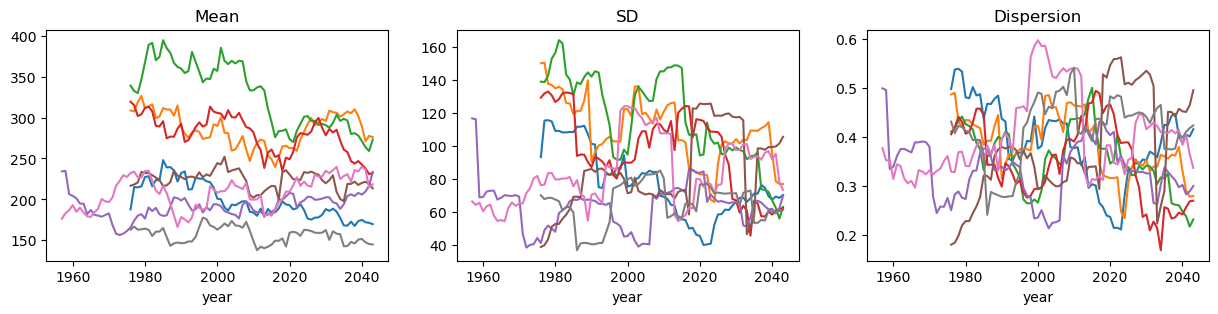

In [122]:
fig, axs = plt.subplots(ncols = 3, figsize = (15,3), dpi = 100)
for fnm in glob.glob(fpath+"ts/*.dat"):
    df = pd.read_csv(fnm, sep = " ", comment = "#", names = ["year", "pr"], index_col = "year")
    df.pr.rolling(15, center = True).mean().plot(ax = axs[0])
    df.pr.rolling(15, center = True).std().plot(ax = axs[1])
    (df.pr.rolling(15, center = True).std() / df.pr.rolling(15, center = True).mean()).plot(ax = axs[2])
    
axs[0].set_title("Mean")
axs[1].set_title("SD")
axs[2].set_title("Dispersion")

### CORDEX

Text(0.5, 1.0, 'Dispersion')

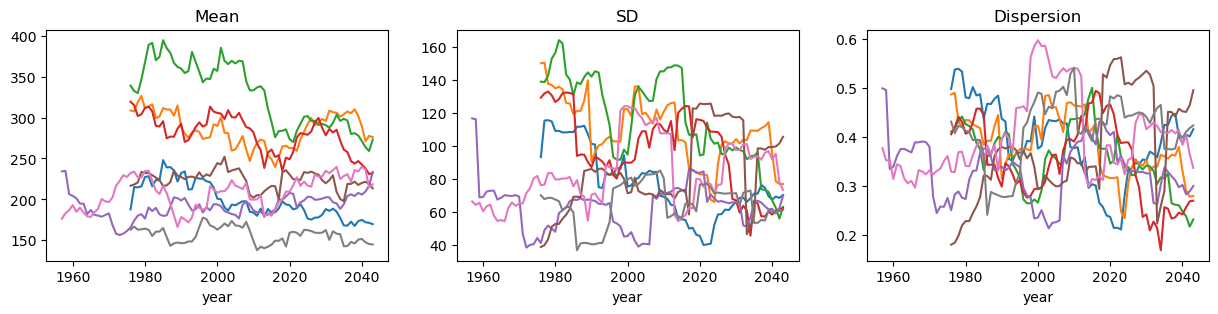

In [43]:
fig, axs = plt.subplots(ncols = 3, figsize = (15,3), dpi = 100)
for fnm in glob.glob(fpath+"ts/*.dat"):
    df = pd.read_csv(fnm, sep = " ", comment = "#", names = ["year", "pr"], index_col = "year")
    df.pr.rolling(15, center = True).mean().plot(ax = axs[0])
    df.pr.rolling(15, center = True).std().plot(ax = axs[1])
    (df.pr.rolling(15, center = True).std() / df.pr.rolling(15, center = True).mean()).plot(ax = axs[2])
    
axs[0].set_title("Mean")
axs[1].set_title("SD")
axs[2].set_title("Dispersion")

### HighResMIP

Text(0.5, 1.0, 'Dispersion')

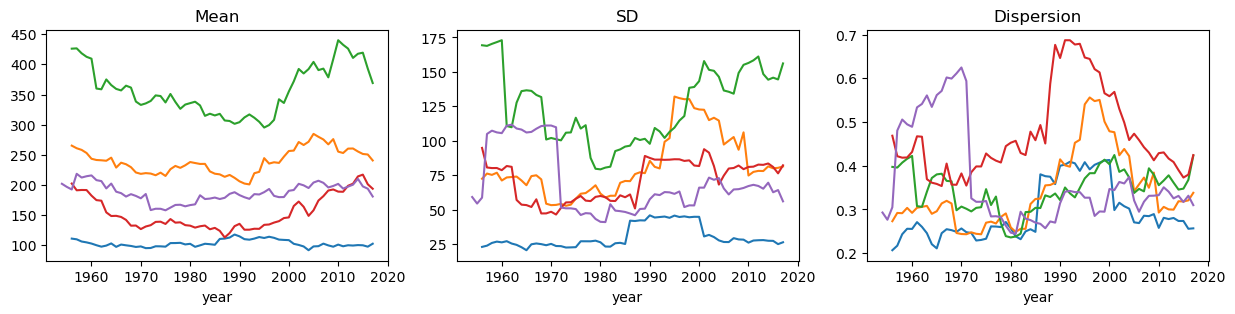

In [123]:
fig, axs = plt.subplots(ncols = 3, figsize = (15,3), dpi = 100)
for fnm in glob.glob(fpath+"hiresmip-ts/*.dat"):
    df = pd.read_csv(fnm, sep = " ", comment = "#", names = ["year", "pr"], index_col = "year")
    df.pr.rolling(15, center = True).mean().plot(ax = axs[0])
    df.pr.rolling(15, center = True).std().plot(ax = axs[1])
    (df.pr.rolling(15, center = True).std() / df.pr.rolling(15, center = True).mean()).plot(ax = axs[2])
    
axs[0].set_title("Mean")
axs[1].set_title("SD")
axs[2].set_title("Dispersion")

# Plots of estimated model parameters
Parameters were estimated in R, but it's easier to plot them nicely here

In [104]:
df_gmst = pd.read_csv("bootci_dI_rel.csv", index_col = 0)
df_nino = pd.read_csv("bootci_dI_rel_nino.csv", index_col = 0)
df_pdo = pd.read_csv("bootci_dI_rel_pdo.csv", index_col = 0)
df_mjo = pd.read_csv("bootci_dI_rel_mjo.csv", index_col = 0)

df_gmst, df_nino, df_pdo, df_mjo = [df[[c for c in sorted(df.columns, reverse = True) if not "amo" in c]] for df in [df_gmst, df_nino, df_pdo, df_mjo]]

ds_cols = {"mswep" : "tab:blue", "chirps" : "tab:orange", "era5" : "tab:green"}

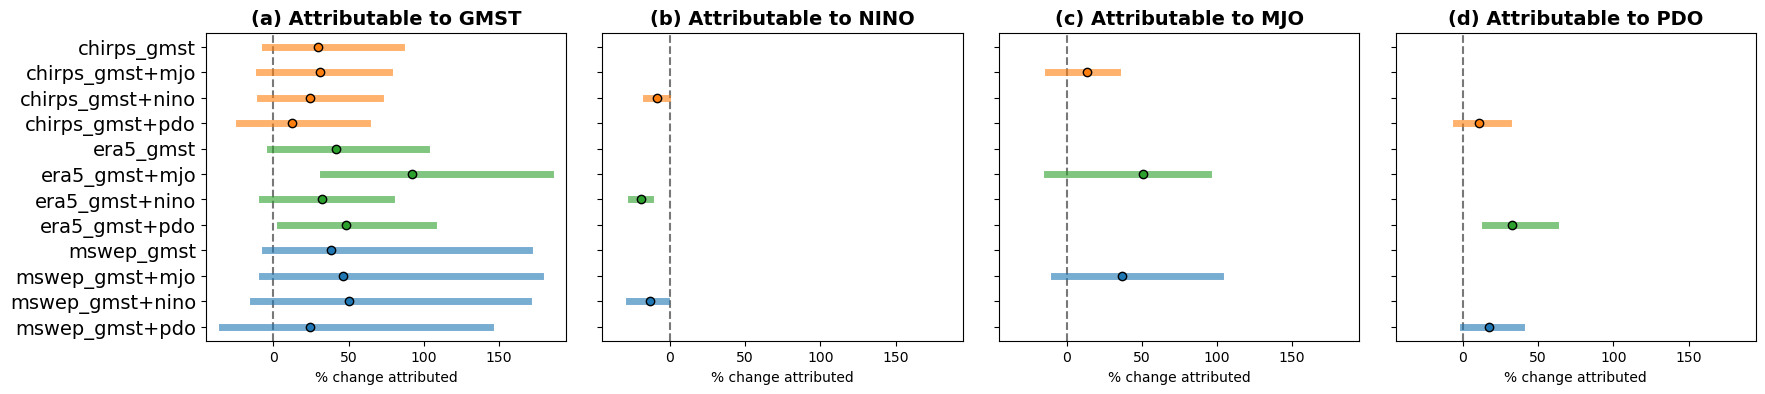

In [119]:
fig, axs = plt.subplots(ncols = 4, figsize = (20,4), dpi = 100, sharey = True, sharex = True)
plt.subplots_adjust(wspace = 0.1)
n = len(df_gmst.columns)

for i in range(4):
    ax = axs[i]
    m = ["gmst", "nino", "mjo", "pdo"][i]
    df = eval("df_"+m)

    ax.axvline(0, color = "k", ls = "--", alpha = 0.53)
    for k in range(n):

        r = df_gmst.columns[k]
        ds = r.split("_")[0]

        ax.plot(df.loc[["2.5%","97.5%"],r], [k,k], color = ds_cols[ds], alpha = 0.6, lw = 5)
        ax.plot(df.loc["bestimate",r], k, color = ds_cols[ds], marker = "o", mec = "k")

    ax.set_yticks(range(n))
    ax.set_yticklabels(df_gmst.columns, size = 14)
    ax.set_title("("+["a","b","c","d"][i]+") Attributable to "+m.upper(), fontweight = "bold", size = 14)

    ax.set_xlabel("% change attributed")

plt.savefig("fig/modes-of-variability.png")

In [121]:
df_pdo

,mswep_gmst+pdo,mswep_gmst+nino,mswep_gmst+mjo,mswep_gmst,era5_gmst+pdo,era5_gmst+nino,era5_gmst+mjo,era5_gmst,chirps_gmst+pdo,chirps_gmst+nino,chirps_gmst+mjo,chirps_gmst
bestimate,17.450640,NaN,NaN,NaN,32.640648,NaN,NaN,NaN,10.571882,NaN,NaN,NaN
2.5%,-0.235920,NaN,NaN,NaN,14.740046,NaN,NaN,NaN,-4.356585,NaN,NaN,NaN
97.5%,38.858357,NaN,NaN,NaN,61.189026,NaN,NaN,NaN,29.967767,NaN,NaN,NaN
